August: Final Mackenzie Canyon bathymetry.

In [23]:
from math import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.cm as cm
import netCDF4 as nc
from netCDF4 import Dataset
import time
%matplotlib inline

### Bathymetry Functions

The original functions were created some time ago and modified by subsequent users. The original code can be found in https://bitbucket.org/canyonsubc/buildcanyon/src/f2380a66a5fe4fc9e373e46f409a57c5fa4b8f9d/PythonModulesMITgcm/BathyPythonTools.py. 

I cleaned up the code and modified it according to what I saw fit. If there is a problem in the future, I suggest referring back to the original code to check if I misunderstood something. The version below is working and sections have been added to further fine-tune the bathymetry to look like Mackenzie Canyon.

The code is a work in progress as I learn more about Mackenzie Canyon bathymetry.

In [29]:
def tanktopo(y, y_base, y_break, y_coast,
             fluid_depth, z_bottom, z_break, z_wall):
    
    """ This function generates the topographical profile of the continental
    slope and shelf without the canyon. The profile is created in parts using
    the equation of a line: topography = z2 = (m * y2) - (m* y1) + z1, where
    the values for y represent key distances along the cross-shore direction
    and the values for z2 are the calculated depths based on a known z1 depth.
    """
    
    sls_ct = (z_wall - z_break) / (y_coast - y_break)
    sls_sb = (z_break - z_bottom) / (y_break - y_base)
    topo_sp = np.zeros(len(y))
    slope_profile = np.zeros(len(y))
   
    for jj in np.arange(len(y)):

        if y[jj] > y_base and y[jj] <= y_break:
            topo_sp[jj] = (sls_sb * y[jj]) - (sls_sb * y_base) + z_bottom
                    
        elif y[jj] > y_break and y[jj] < y_coast:
            topo_sp[jj] = (sls_ct * y[jj]) - (sls_ct * y_break) + z_break
                                  
        elif y[jj] >= y_coast:
            topo_sp[jj] = z_wall

        slope_profile[jj] = topo_sp[jj] - fluid_depth
        
    return slope_profile
   
def canyontopo(y, y_base, y_break, y_head, y_coast,
               fluid_depth, z_bottom, z_break, z_wall):
    
    """ This function generates the topographical profile for the canyon along
    its axis (cross-shore direction). Similar to tanktopo, the profile is
    formed using a collection of lines.
    """
    
    slc_L = (z_break - z_bottom) / (y_head - y_base)
    slc_ct = (z_wall - z_break) / (y_coast - y_head)
    topo_cp = np.zeros(len(y))
    canyon_profile = np.zeros(len(y))
    
    for ii in np.arange(len(y)):
        
        if y[ii] <= y_base:
            topo_cp[ii] = z_bottom
        
        elif y[ii] > y_base and y[ii] <= y_head:
            topo_cp[ii] = (slc_L * y[ii]) - (slc_L * y_base) + z_bottom
                    
        elif y[ii] > y_head and y[ii] <= y_coast :      
            topo_cp[ii] = (slc_ct * y[ii]) - (slc_ct * y_head) + z_break
          
        elif y[ii] > y_coast:
            topo_cp[ii] = z_wall
        
        canyon_profile[ii] = topo_cp[ii] - fluid_depth
 
    return canyon_profile
   
def widthprofile(y, y_base, y_break, y_head, y_coast, cR,
                 w_break, w_mid, w_head, p):
    
    """ This function defines the width profile of the canyon (top-down view).
    The width of the canyon is defined for all distances in the cross-shore
    direction. 
    """

    sigmaa = 1.0 / ((9e-7) * cR)
    half = -w_break / 2.0+ w_mid / 2.0
    e = (L / 2.0 - sigmaa * half**2) / half**p 
    sc = 1
    dG_dxh = p * e * (w_head - w_break / 2)**(p-1) + 2 * sigmaa * (w_head - w_break)
    dh = 0.5 / dG_dxh / sc
    Ah = (w_break - w_head) / (y_base - y_head)**2;
    wp = np.zeros(len(y))

    for l in np.arange(len(y)):

            if y[l] <= y_base:
                wp[l] = w_break

            elif y[l] > y_base and y[l] <= y_head:   
                wp[l] = Ah * (y[l] - y_head)**2 + dh * (y[l] - y_head) + w_head

            elif y[l] > y_head and y[l] <= y_coast:
                wp[l] = wp[l-1]
            
            elif y[l] > y_coast:
                wp[l] = w_break
                
        
    width_profile = wp 
    return width_profile

def make_topo_smooth(y, y_base, y_break, y_head, y_coast, cR,
                     x, x_wall, w_break, w_mid, w_head, p,
                     fluid_depth, z_bottom, z_break, z_wall):
    
    """ This function returns the depth field of the continental slope and
    shelf with a sech-shaped canyon. 
    
    :arg y: Array of cross-shore distances
    :arg y_base: Distance to the base of the continental slope
    :arg y_break: Distance to the shelf break
    :arg y_head: Distance to the canyon head
    :arg y_coast: Distance beyond y_head where shelf flattens
    :arg cR: Radius of curvature at the shelf break depth
    :arg x: Array of alongshore distances
    :arg x_wall: Width of the Domain
    :arg w_break: Width of the canyon at the shelf break
    :arg w_mid: Width of the canyon half-way along its length
    :arg w_head: Width of the canyon head
    :arg p: Geometric parameter used to help shape of canyon
    :arg fluid_depth: Total height of the fluid in the domain.
    :arg z_bottom: Depth of the deep ocean (measured upward)
    :arg z_break: Depth of the shelf break (measured upward)
    :arg z_wall: Depth of shelf beyond y_coast (measured upward)
    """
    
    # Topography without the canyon
    slope_profile = tanktopo(y, y_base, y_break, y_coast,
                             fluid_depth, z_bottom, z_break, z_wall)
    
    # Slope of the canyon
    canyon_profile = canyontopo(y, y_base, y_break, y_head, y_coast,
                                fluid_depth, z_bottom, z_break, z_wall)
  
    # Slope of the canyon as well as the shape
    width_profile = widthprofile(y, y_base, y_break, y_head, y_coast, cR,
                                 w_break, w_mid, w_head, p)
  
    # Depth of the canyon (negative values set to zero)
    canyondepth = slope_profile - canyon_profile
  
    canyondepth[canyondepth < 0] = 0
  
    # Sech shaped canyon
    topography = np.zeros((len(y),len(x)))
    for j in np.arange(len(x)):
        topography[:,j] = (slope_profile - canyondepth * 
                           (1.0 / (np.cosh(0.5 / width_profile * (x[j] - (0.5 * x_wall))))**50))
    #topography=np.transpose(topography)
    topo = -1* topography[0:-1, :]
   
    return topo

### Dimensions specific to Mackenzie Canyon

These dimensions were measured for Mackenzie Canyon in plot_mackenzie.ipynb. They can be tweaked if I decide to change how the measurements were made. w represents width, y cross-shore direction, x alongshore direction, and z is the depth at key topographical regions, i.e. deep ocean, shelf break, and "wall". Means were used for the break and base because the canyon has two sides, each of which has a different dimension.

The *fluid_depth* was taken as 1300 m. All of the cross-shore distance were calculated from this isobath. However, when the idealized bathymetry was created, the domain went beyond the 1300 m isobath, but still ended at the same *y_wall* location. Therefore, this extra space that was added to the idealized domain was added to all the cross-shore distances as *adjust*. As in the code, *adjust* is the difference in distance betweeen the 1300 m isobath and the point where the realistic domain starts.

**Values that you need from plot_mackenzie: mouth, length, width_f.**

**Match with real domain in plot_mackenzie: x_wall, y_wall**

In [30]:
# Alongshore
w_break = 62681.735776859277  
w_mid = 46456.969337226466  
w_head = 14142.13562373095 
width_f = 62681.735776859277
x_wall = width_f * 7

# Adjustments
mouth = 51865.209919559762
length = 74607.305272339116
y_wall_1300 = 174731.93755006552
y_wall = (mouth + length) * 2.57
adjust = y_wall - y_wall_1300

# Cross-shore
cR = 9246.0
L = 93744.0     
y_base = np.mean([16500.0,7000.0]) + adjust 
y_break = np.mean([38000.0, 57500.0]) + adjust 
y_coast = 148105.0 + adjust 
y_head = y_break + L

# Depths
fluid_depth = 1300.0
z_bottom = fluid_depth - fluid_depth
z_break = fluid_depth - 80.0
z_wall = fluid_depth - 40.0 
p = 4.0

### Setting up the grid

This section could use some revision to make it simpler. The code was based off of Karina RM's notebook in https://bitbucket.org/canyonsubc/buildcanyon. This is where the idealized grid size is defined. When calling the bathymetry functions, note that y_edge and x are used instead of y and x.

In [31]:
#xsize = 501
xsize = 101
xgrd_all = np.arange(0, xsize, 1)
xgrd_bounds = [0, xsize-1]
xval_bounds = [0, x_wall]
xval_all = np.interp(xgrd_all, xgrd_bounds, xval_bounds)
x_edge = np.zeros(xsize)
x_edge[:] = xval_all[:]
x = ((x_edge[1:] + x_edge[0:-1])/2)

#ysize = 351
ysize = 101
ygrd_all = np.arange(0, ysize, 1)
ygrd_bounds = [0, ysize-1]
yval_bounds = [0, y_wall]
yval_all = np.interp(ygrd_all, ygrd_bounds, yval_bounds)
y_edge = np.zeros(ysize)
y_edge[:] = yval_all[:]
y = ((y_edge[1:] + y_edge[0:-1])/2)

### Make bathymetry

In [32]:
bathymetry = make_topo_smooth(y_edge, y_base, y_break, y_head, y_coast, cR,
                              x, x_wall, w_break, w_mid, w_head, p,
                              fluid_depth, z_bottom, z_break, z_wall)
bathymetry.shape

(100, 100)

### Mackenzie Canyon:

This plot is used to check that the function results have the same dimension as those of mackenzie canyon.

(100000, 300000)

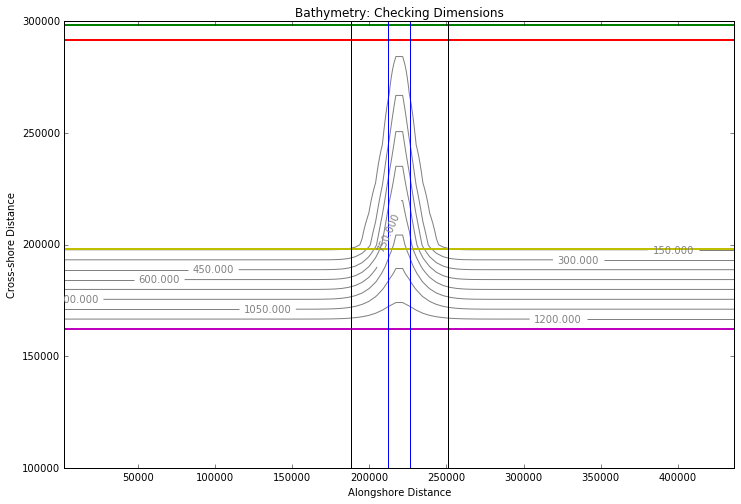

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
ax.set_title('Bathymetry: Checking Dimensions')
ax.set_xlabel('Alongshore Distance'); ax.set_ylabel('Cross-shore Distance')
X, Y = np.meshgrid(x, y)
cs = ax.contour(X, Y, bathymetry, 10, colors='grey', linestyles='solid')
CS = ax.contour(X, Y, bathymetry, levels = [-1300, -80, -60, -40.1], colors='grey',linestyles='-')
ax.clabel(cs, inline=1); ax.clabel(CS, inline=1)

# markers
ys = [y_base, y_break, y_head, y_coast]
labs = ['base', 'break', 'head', 'coast']
cs = ['m', 'y', 'r', 'g']
for i, j, k in zip(ys, labs, cs):
    ax.axhline(i, c=k, label=j, linewidth=2)
ax.axvline((x_wall/2)-(w_head/2)); plt.axvline((x_wall/2)+(w_head/2), label='head width')
ax.axvline((x_wall/2)+(w_break/2), c='k'); plt.axvline((x_wall/2)-(w_break/2), c='k', label='mouth width')
#ax.legend(ncol=7)
ax.set_ylim([100000, 300000])

This plot is used to cleanly see the depth profile of the idealized canyon bathymetry. Note that all depths beyond 40.1 are constant at 40 m, which is from the "coast" to the "wall".

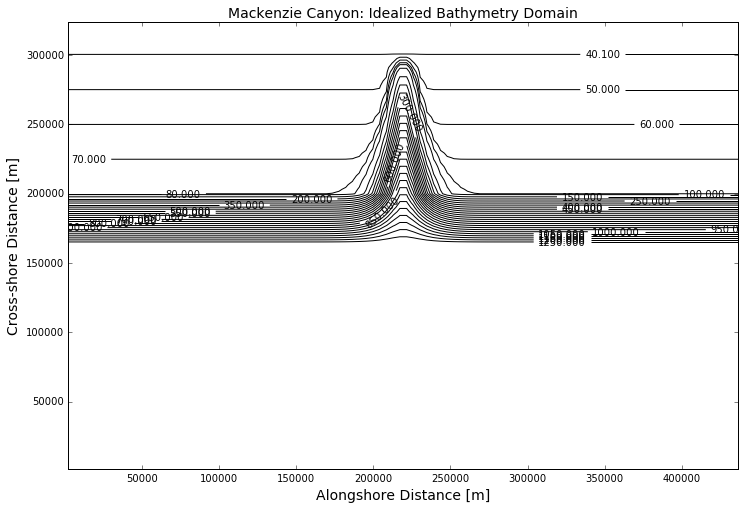

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
ax.set_title('Mackenzie Canyon: Idealized Bathymetry Domain', fontsize=14)
ax.set_xlabel('Alongshore Distance [m]', fontsize=14); ax.set_ylabel('Cross-shore Distance [m]', fontsize=14)
cs = ax.contour(X, Y, bathymetry, 25, colors='k', linestyles='solid')
CS = ax.contour(X, Y, bathymetry, levels = [40.1, 60, 70, 80, 1300], colors='k',linestyles='-')
ax.clabel(cs, inline=1); ax.clabel(CS, inline=1)
fig.savefig('seminar1.png', format='png', dpi=500, facecolor=fig.get_facecolor(), transparent=True)

These are the cross-shore profiles of the shelf and canyon and also the width profile of the canyon.

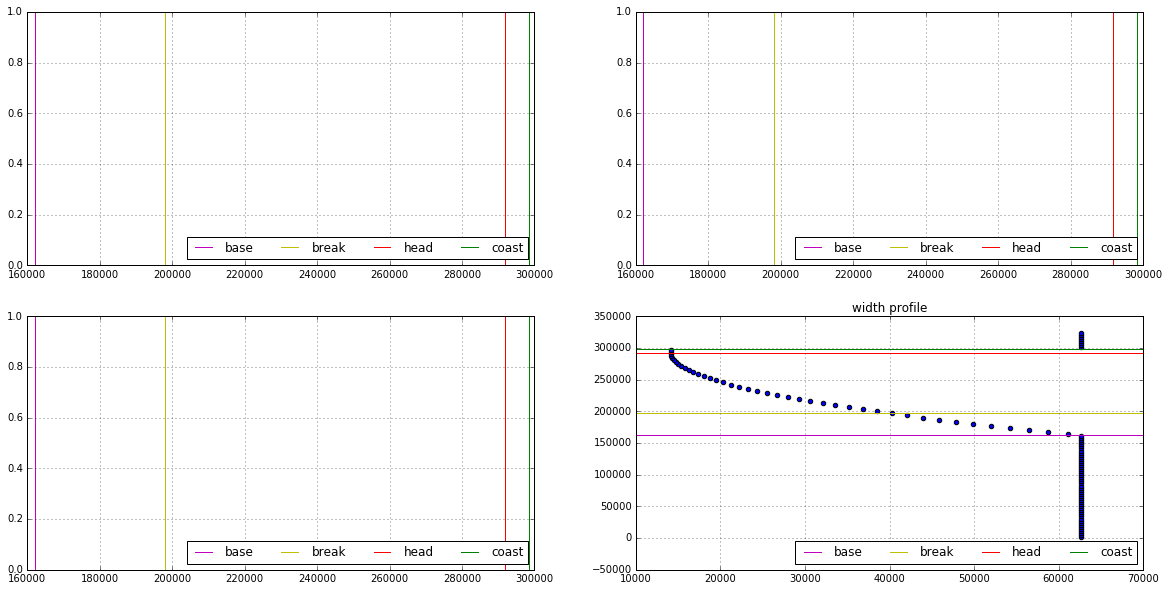

In [37]:
fig, [(ax1, ax2),(ax3, ax4)] = plt.subplots(2, 2, figsize=(20,10))
#ax1.plot(y, bathymetry[:, 255] ); ax1.set_title('inner shelf - 255')
#ax2.plot(y, bathymetry[:, 400] ); ax2.set_title('outer shelf - 400')
#ax3.plot(y, bathymetry[:, 250] ); ax3.set_title('canyon profile')

for ax, n in zip([ax1, ax2, ax3, ax4], np.arange(4)):
    ys = [y_base, y_break, y_head, y_coast]
    labs = ['base', 'break', 'head', 'coast']
    cs = ['m', 'y', 'r', 'g']
    for i, j, k in zip(ys, labs, cs):
        if ax == ax4:
            ax.axhline(i, c=k, label=j)
            ax.legend(ncol=5, loc=4)
        else:
            ax.axvline(i, c=k, label=j)
            ax.legend(ncol=5, loc=4)
            #ax.set_ylim([-150, 0]) 
    ax.grid()
        
width_test = widthprofile(y, y_base, y_break, y_head, y_coast, cR, w_break, w_mid, w_head, p)
ax4.scatter(width_test, y); ax4.set_title('width profile')

### Making bathymetry file

_1 is 500x350 and _02 is 100x100

In [38]:
dataset = Dataset('Bathy_Mackenzie_02.nc', 'w')
x = dataset.createDimension('x', 100)
y = dataset.createDimension('y', 100)

X = dataset.createVariable('X', 'f8', ('y','x'))
Y = dataset.createVariable('Y', 'f8', ('y','x'))
Bathymetry = dataset.createVariable('Bathymetry', 'f8', ('y','x'))

dataset.title = 'Mackenzie Canyon Bathymetry 02'
dataset.author = 'Idalia A. Machuca'
dataset.institution = 'Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia'
dataset.source = 'bitbucket.org/CanyonsUBC/mackenzie_canyon/bathymetry/notebooks/make_mackenzie.ipynb'
dataset.timeStamp = time.ctime(time.time())
X.standard_name = 'Along-Shore Distance'
X.units = 'm'
Y.standard_name = 'Cross-Shore Distance'
Y.units = 'm'
Bathymetry.standard_name = 'Bathymetry'
Bathymetry.units = 'm'
Bathymetry.positive = 'upward'

X[:] = X[:]
Y[:] = Y[:]
Bathymetry[:] = bathymetry[:]

dataset.close()

In [39]:
bathy_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/notebooks/Bathy_Mackenzie_02.nc')
bathy_file, bathy_file.variables

(<class 'netCDF4._netCDF4.Dataset'>
 root group (NETCDF4 data model, file format HDF5):
     title: Mackenzie Canyon Bathymetry 02
     author: Idalia A. Machuca
     institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
     source: bitbucket.org/CanyonsUBC/mackenzie_canyon/bathymetry/notebooks/make_mackenzie.ipynb
     timeStamp: Mon Oct  3 17:10:11 2016
     dimensions(sizes): x(100), y(100)
     variables(dimensions): float64 X(y,x), float64 Y(y,x), float64 Bathymetry(y,x)
     groups: , OrderedDict([('X', <class 'netCDF4._netCDF4.Variable'>
               float64 X(y, x)
                   standard_name: Along-Shore Distance
                   units: m
               unlimited dimensions: 
               current shape = (100, 100)
               filling on, default _FillValue of 9.969209968386869e+36 used),
              ('Y', <class 'netCDF4._netCDF4.Variable'>
               float64 Y(y, x)
                   standard_name: Cross-Shore Distance

In [40]:
AS = bathy_file.variables['X']
CS = bathy_file.variables['Y']
bathy_plot = bathy_file.variables['Bathymetry']

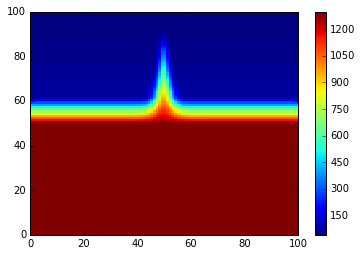

In [42]:
plt.pcolor(bathy_plot)
plt.colorbar()